In [101]:
import numpy as np
from scipy.integrate import quad
from scipy.optimize import minimize
from PlotSettings import MainColor1, MainColor2, MainColor3, BackgroundColor1, BackgroundColor2, BackgroundColor3, Gray1, Gray2, plt

alphaDM = 0.01


############## Functions ###############
def sigmatransfer(V, mphi, mchi, alphax):
    w = 300 * (mphi / 10) * (10 / mchi)
    st = (275.73) * (alphax / 1e-2) ** 2 * (mchi / 10) * (10 / mphi) ** (4)
    sv = 2 * st * (w ** 4 / V ** 4) * (2 * np.log(1.0 + V ** 2 / (2 * w ** 2)) - np.log(1.0 + V ** 2 / (w ** 2)))
    return sv


def sigmaviscosity(V, mphi, mchi, alphax):
    w  = 300*(mphi/(10))*(10/(mchi))
    beta = V/w
    st = (275.73)*(alphax/0.01)**2*(mchi/10.0)*(10.0/(mphi))**(4)

    if beta < 0.01:
        sv = 3/6*st
    else:
        sv = 3*st*(1/beta**6)*( (2+beta**2)*np.log(1+ beta**2)- 2*beta**2 )
    return sv



def Integrand_sigmatransfer(v, v0, M, m, alphax):
    return sigmatransfer(v, M, m, alphax)*v*np.exp(-0.5*v**2/v0**2)*v**2


def Integrand_sigmaviscosity(v, v0, M, m, alphax):
    return sigmaviscosity(v, M, m, alphax)*v*np.exp(-0.5*v**2/v0**2)*v**2


def Average_sigmatransfer(v0, M, m, alphax):
    sigma2_MB = v0**2*np.pi*(3*np.pi - 8)/np.pi
    vmax = 2*np.sqrt(sigma2_MB)

    Prefactor = 4*np.pi/((2*np.pi*v0**2)**1.5 )
    Integral = quad(Integrand_sigmatransfer, 0., vmax, args=(v0, M, m, alphax))[0]
    return Prefactor*Integral

def Average_sigmaviscosity(v0, M, m, alphax):
    sigma2_MB = v0**2*np.pi*(3*np.pi - 8)/np.pi
    vmax = 2*np.sqrt(sigma2_MB)

    Prefactor = 4*np.pi/((2*np.pi*v0**2)**1.5 )
    Integral = quad(Integrand_sigmaviscosity, 0., vmax, args=(v0, M, m, alphax), limit=100)[0]
    return Prefactor*Integral


############## Camila Data ###############

CamilaData_Fig7 = np.loadtxt('Data-Sets/Data_Fig7_Correa_2021.txt')
VelocityData = CamilaData_Fig7[:,0]
Velocity_16_Percentile = CamilaData_Fig7[:,1]
Velocity_84_Percentile = CamilaData_Fig7[:,2]
VelocityData_Err = ( (VelocityData - Velocity_16_Percentile) + (Velocity_84_Percentile - VelocityData) ) /2

CrossSectionData = CamilaData_Fig7[:,3]
CrossSectionData_16_Percentile = CamilaData_Fig7[:,4]
CrossSectionData_84_Percentile = CamilaData_Fig7[:,5]

CrossSectionData_Err = ((CrossSectionData - CrossSectionData_16_Percentile) + (CrossSectionData_84_Percentile - CrossSectionData) )/2


############## Complete Data ###############

CompleteData = np.loadtxt('Data-Sets/FullData.csv')
x_data = CompleteData[:,0]
y_data = CompleteData[:,1]
err_x_data = CompleteData[:,2]
err_y_data = CompleteData[:,3]



########## Compute the fit #############
def compute_fit(Xsec, alphax):


    ############# Define a chi square ###########
    def compute_chi2(free_params, alphax, x=x_data, data=y_data, err=(err_x_data, err_y_data)):
        #Compute model
        M, m = free_params
        model = [Xsec(x, M, m, alphax) for x in x]

        errx, erry = err
        #chi2 computation
        chi2y= np.sum((data-model)**2/erry**2)
        chi2x= np.sum((x - 2*x*np.sqrt(2/np.pi))**2/errx**2)
        return chi2y #+ chi2x


    M_ini, m_ini = 50, 6
    initial = [M_ini, m_ini]
    soln = minimize(compute_chi2, initial, args=(alphax, x_data, y_data, (err_x_data, err_y_data)), method='Nelder-mead')

    M_bf, m_bf = soln.x
    print("alpha_X = ", alphax)

    print("Best Fit Parameters")
    print('M = {0:.2f} MeV'.format(M_bf))
    print('m = {0:.2f} GeV'.format(m_bf))
    print("Chi-squared:", compute_chi2((M_bf, m_bf), alphax))


In [106]:
compute_fit(Average_sigmatransfer, 0.01)

C:\Users\Nicolás\AppData\Local\Temp\ipykernel_43152\3318437995.py:43: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  Integral = quad(Integrand_sigmatransfer, 0., vmax, args=(v0, M, m, alphax))[0]


alpha_X =  0.01
Best Fit Parameters
M = 29.55 MeV
m = 20.75 GeV
Chi-squared: 503321.540662174


In [103]:
compute_fit(Average_sigmaviscosity, 0.01)

C:\Users\Nicolás\AppData\Local\Temp\ipykernel_43152\3318437995.py:51: IntegrationWarning: The maximum number of subdivisions (100) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  Integral = quad(Integrand_sigmaviscosity, 0., vmax, args=(v0, M, m, alphax), limit=100)[0]
C:\Users\Nicolás\AppData\Local\Temp\ipykernel_43152\3318437995.py:51: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  Integral = quad(Integrand_sigmaviscosity, 0., vmax, args=(v0, M, m, alphax), limit=100)[0]


alpha_X =  0.01
Best Fit Parameters
M = 29.83 MeV
m = 21.99 GeV
Chi-squared: 501625.1612703092


C:\Users\Nicolás\AppData\Local\Temp\ipykernel_43152\3318437995.py:51: IntegrationWarning: The maximum number of subdivisions (100) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  Integral = quad(Integrand_sigmaviscosity, 0., vmax, args=(v0, M, m, alphax), limit=100)[0]
C:\Users\Nicolás\AppData\Local\Temp\ipykernel_43152\3318437995.py:43: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
 

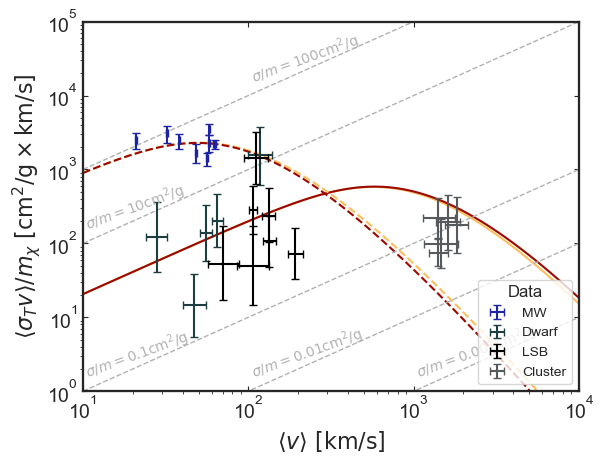

In [111]:
"""
//////////// Plots ////////////
"""

#for the plots
DwarfData = np.loadtxt('Data-Sets/DwarfDataPlot.csv', delimiter='\t')
Dwarf_x =     DwarfData[:,0]
Dwarf_y =     DwarfData[:,1]
Dwarf_Err_l = DwarfData[:,2]
Dwarf_Err_r = DwarfData[:,3]
Dwarf_Err_d = DwarfData[:,4]
Dwarf_Err_u = DwarfData[:,5]

GalaxyData = np.loadtxt('Data-Sets/GalaxyDataPlot.csv', delimiter='\t')
Galaxy_x = GalaxyData[:,0]
Galaxy_y = GalaxyData[:,1]
Galaxy_Err_l = GalaxyData[:,2]
Galaxy_Err_r = GalaxyData[:,3]
Galaxy_Err_d = GalaxyData[:,4]
Galaxy_Err_u = GalaxyData[:,5]

ClusterData = np.loadtxt('Data-Sets/ClusterDataPlot.csv', delimiter='\t')
Cluster_x = ClusterData[:,0]
Cluster_y = ClusterData[:,1]
Cluster_Err_l = ClusterData[:,2]
Cluster_Err_r = ClusterData[:,3]
Cluster_Err_d = ClusterData[:,4]
Cluster_Err_u = ClusterData[:,5]

v_array = np.logspace(1., 4, 100)
v0 = v_array*np.sqrt(np.pi)/4

sigvm_array = np.zeros(100)
sigvm_array_t = np.zeros(100)
sigvm_array2 = np.zeros(100)
sigvm_array3 = np.zeros(100)



# Create a figure and axis object
fig, ax = plt.subplots()

alphaDM, alphaDM2, alphaDM3 = 0.01, 0.01, 0.01
mZp, mZp2, mZp3 = 30, 46, 19
mDM, mDM2, mDM3 = 22, 7, 161

for i in range(100):
    sigvm_array[i] = Average_sigmaviscosity(v0[i], mZp, mDM, alphaDM)
    sigvm_array_t[i] = Average_sigmatransfer(v0[i], mZp, mDM, alphaDM)
    sigvm_array2[i] = Average_sigmaviscosity(v0[i], mZp3, mDM3, alphaDM3)
    sigvm_array3[i] = Average_sigmatransfer(v0[i], mZp3, mDM3, alphaDM3)

# Model Plot
model_t, = ax.plot(v_array, sigvm_array_t, color=BackgroundColor3, label='Chi-2 Fit')
model1, = ax.plot(v_array, sigvm_array, color=MainColor1, label='Chi-2 Fit')
model2, = ax.plot(v_array, sigvm_array2, color=BackgroundColor3, linestyle='dashed', label='Viscosity')
model3, = ax.plot(v_array, sigvm_array3, color=MainColor1, linestyle='dashed', label='Transfer')
#first_legend = ax.legend(handles=[model1, model2, model3], loc=2, title='Models')
#ax.add_artist(first_legend)


# Cross section diagonals
DiagonalsColor = Gray2
Diagonalswidth = 1
ax.plot(v_array, 0.001*v_array, color=DiagonalsColor, linestyle='dashed', lw=Diagonalswidth)
ax.text(1000, 1.5, r'$ \sigma/m = 0.001 \mathrm{cm^2/g}$', size=10, rotation=20, color=DiagonalsColor)
ax.plot(v_array, 0.01*v_array, color=DiagonalsColor, linestyle='dashed', lw=Diagonalswidth)
ax.text(100, 1.5, r'$ \sigma/m = 0.01 \mathrm{cm^2/g}$', size=10, rotation=20, color=DiagonalsColor)
ax.plot(v_array, 0.1*v_array, color=DiagonalsColor, linestyle='dashed', lw=Diagonalswidth)
ax.text(10, 1.5, r'$ \sigma/m = 0.1 \mathrm{cm^2/g}$', size=10, rotation=20, color=DiagonalsColor)
ax.plot(v_array, 10*v_array, color=DiagonalsColor, linestyle='dashed', lw=Diagonalswidth)
ax.text(10, 150, r'$ \sigma/m = 10 \mathrm{cm^2/g}$', size=10, rotation=20, color=DiagonalsColor)
ax.plot(v_array, 100*v_array, color=DiagonalsColor, linestyle='dashed', lw=Diagonalswidth)
ax.text(100, 1.5e4, r'$ \sigma/m = 100 \mathrm{cm^2/g}$', size=10, rotation=20, color=DiagonalsColor)

# Data
data1 = ax.errorbar(VelocityData, CrossSectionData, CrossSectionData_Err , VelocityData_Err , ls='', color=MainColor2, capsize=3, label='MW')
data2 = ax.errorbar(Dwarf_x, Dwarf_y, (Dwarf_Err_d, Dwarf_Err_u), (Dwarf_Err_l, Dwarf_Err_r), ls='', color=BackgroundColor2, capsize=3, label='Dwarf')
data3 = ax.errorbar(Galaxy_x, Galaxy_y, (Galaxy_Err_d, Galaxy_Err_u), (Galaxy_Err_l, Galaxy_Err_r), ls='', color='k', capsize=3, label='LSB')
data4 = ax.errorbar(Cluster_x, Cluster_y, (Cluster_Err_d, Cluster_Err_u), (Cluster_Err_l, Cluster_Err_r), ls='', color=Gray1, capsize=3, label='Cluster')
ax.legend(handles=[data1, data2, data3, data4], loc=4, title='Data')

# Settings
ax.tick_params(top=True, right=True, direction='in')
ax.set_xlabel(r'$\langle v \rangle ~[ \mathrm{km/s}]$')
ax.set_ylabel(r'$\langle\sigma_T v \rangle /m_{\chi} ~[\mathrm{cm^2/g \times km/s}]$')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(1, 1e5)
ax.set_xlim(10, 1e4)


# Save and show the plot
plt.savefig('Plots/GalaxyFit.pdf')
plt.savefig('Plots/GalaxyFit.svg')
plt.show()